In [56]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [57]:
data = pd.read_csv("Top_5_Leagues_23_24.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [58]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.gameId==next_actions.gameId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['gameId' ] = nex.gameId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team','player']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   #dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['player' ]= nex.player
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['gameId','period']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [59]:
data = add_carries(data)

In [60]:
data_carries = data[data['type'] == 'Carry']

In [61]:
data_passes = data[(data['type'] == 'Pass') & (data['outcomeType'] == 'Successful')]

In [87]:
lhs_x_min = 18
lhs_x_max = 42
lhs_y_min = 50
lhs_y_max = 50 + 12

rhs_x_min = 18
rhs_x_max = 42
rhs_y_min = 18
rhs_y_max = 18 + 12

# Function to identify half-space actions and calculate progressive actions
def calculate_progressive_actions(df, x_min, x_max, y_min, y_max):
    df_prog = df.copy()
    df_prog['in_halfspace'] = (df_prog['x'].between(x_min, x_max) & df_prog['y'].between(y_min, y_max))
    df_prog['beginning'] = np.sqrt(np.square(120 - df_prog['x']) + np.square(40 - df_prog['y']))
    df_prog['end'] = np.sqrt(np.square(120 - df_prog['endX']) + np.square(40 - df_prog['endY']))
    df_prog['progressive'] = (df_prog['end'] / df_prog['beginning']) < 0.75
    return df_prog[df_prog['progressive'] & df_prog['in_halfspace']]

# Calculate progressive actions out of left and right half-spaces
prog_lhs_passes = calculate_progressive_actions(data_passes, lhs_x_min, lhs_x_max, lhs_y_min, lhs_y_max)
prog_rhs_passes = calculate_progressive_actions(data_passes, rhs_x_min, rhs_x_max, rhs_y_min, rhs_y_max)
prog_lhs_carries = calculate_progressive_actions(data_carries, lhs_x_min, lhs_x_max, lhs_y_min, lhs_y_max)
prog_rhs_carries = calculate_progressive_actions(data_carries, rhs_x_min, rhs_x_max, rhs_y_min, rhs_y_max)

# Group and aggregate
lhs_passes_grouped = prog_lhs_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='lhs_prog_passes')
rhs_passes_grouped = prog_rhs_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='rhs_prog_passes')
lhs_carries_grouped = prog_lhs_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='lhs_prog_carries')
rhs_carries_grouped = prog_rhs_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='rhs_prog_carries')

# Merge and combine
combined_prog_df = pd.merge(lhs_passes_grouped, rhs_passes_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)
combined_prog_df = pd.merge(combined_prog_df, lhs_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)
combined_prog_df = pd.merge(combined_prog_df, rhs_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)

# Calculate total progressive actions and per 90 numbers
combined_prog_df['total_prog_actions'] = combined_prog_df['lhs_prog_passes'] + combined_prog_df['rhs_prog_passes'] + combined_prog_df['lhs_prog_carries'] + combined_prog_df['rhs_prog_carries']

# Merge with player metadata (e.g., minutes played)
info = pd.read_csv("T5 Leagues Mins 23-24.csv")
info['90s'] = info['Mins'] / 90

# Merge with the main dataframe
combined_prog_df = pd.merge(combined_prog_df, info, on=['player', 'team'], how='left')
combined_prog_df = combined_prog_df[(combined_prog_df['90s'] >= 12) & (combined_prog_df['position'] != 'GK')
                                    & (combined_prog_df['age'] <= 23)]

# Calculate per 90 values
combined_prog_df['rhs_prog_passes_p90'] = combined_prog_df['rhs_prog_passes'] / combined_prog_df['90s']
combined_prog_df['lhs_prog_passes_p90'] = combined_prog_df['lhs_prog_passes'] / combined_prog_df['90s']
combined_prog_df['rhs_prog_carries_p90'] = combined_prog_df['rhs_prog_carries'] / combined_prog_df['90s']
combined_prog_df['lhs_prog_carries_p90'] = combined_prog_df['lhs_prog_carries'] / combined_prog_df['90s']
combined_prog_df['total_prog_actions_p90'] = combined_prog_df['total_prog_actions'] / combined_prog_df['90s']

# Get the top 12 players based on per 90 numbers
top_12_prog_HS = combined_prog_df.sort_values("total_prog_actions_p90", ascending=False).head(20)

top_12_prog_HS

,playerId,player,team,lhs_prog_passes,rhs_prog_passes,lhs_prog_carries,rhs_prog_carries,total_prog_actions,Unnamed: 0,age,position,Mins,Passing Accuracy,90s,rhs_prog_passes_p90,lhs_prog_passes_p90,rhs_prog_carries_p90,lhs_prog_carries_p90,total_prog_actions_p90
947,498386.0,Pau Cubarsí,Barcelona,3.0,8.0,3.0,0.0,14.0,684.0,17.0,D(C),1563.0,91.7,17.366667,0.460653,0.172745,0.000000,0.172745,0.806142
911,445424.0,Murillo,Nottingham Forest,19.0,1.0,5.0,0.0,25.0,179.0,21.0,D(C),2793.0,77.6,31.033333,0.032223,0.612245,0.000000,0.161117,0.805585
1230,389124.0,Ilario Monterisi,Frosinone,0.0,13.0,0.0,0.0,13.0,1483.0,22.0,D(C),1469.0,81.3,16.322222,0.796460,0.000000,0.000000,0.000000,0.796460
839,422136.0,Christopher Wooh,Rennes,1.0,7.0,2.0,2.0,12.0,2558.0,22.0,D(C),1388.0,85.8,15.422222,0.453890,0.064841,0.129683,0.129683,0.778098
875,430301.0,Rafa Marín,Deportivo Alaves,10.0,7.0,2.0,0.0,19.0,847.0,22.0,D(C),2441.0,82.8,27.122222,0.258091,0.368701,0.000000,0.073740,0.700533
876,430511.0,Mika Mármol,Las Palmas,11.0,2.0,11.0,0.0,24.0,771.0,22.0,D(C),3181.0,89,35.344444,0.056586,0.311223,0.000000,0.311223,0.679032
749,395320.0,Jon Pacheco,Real Sociedad,5.0,2.0,4.0,0.0,11.0,781.0,23.0,D(C),1521.0,87.3,16.900000,0.118343,0.295858,0.000000,0.236686,0.650888
772,399826.0,Illia Zabarnyi,Bournemouth,2.0,16.0,4.0,2.0,24.0,273.0,21.0,D(C),3330.0,81.6,37.000000,0.432432,0.054054,0.054054,0.108108,0.648649
642,368091.0,Eric García,Girona,2.0,8.0,1.0,6.0,17.0,644.0,23.0,D(CR),2641.0,90.2,29.344444,0.272624,0.068156,0.204468,0.034078,0.579326
668,374631.0,Marc Guéhi,Crystal Palace,13.0,0.0,0.0,0.0,13.0,259.0,23.0,D(C),2023.0,87.2,22.477778,0.000000,0.578349,0.000000,0.000000,0.578349


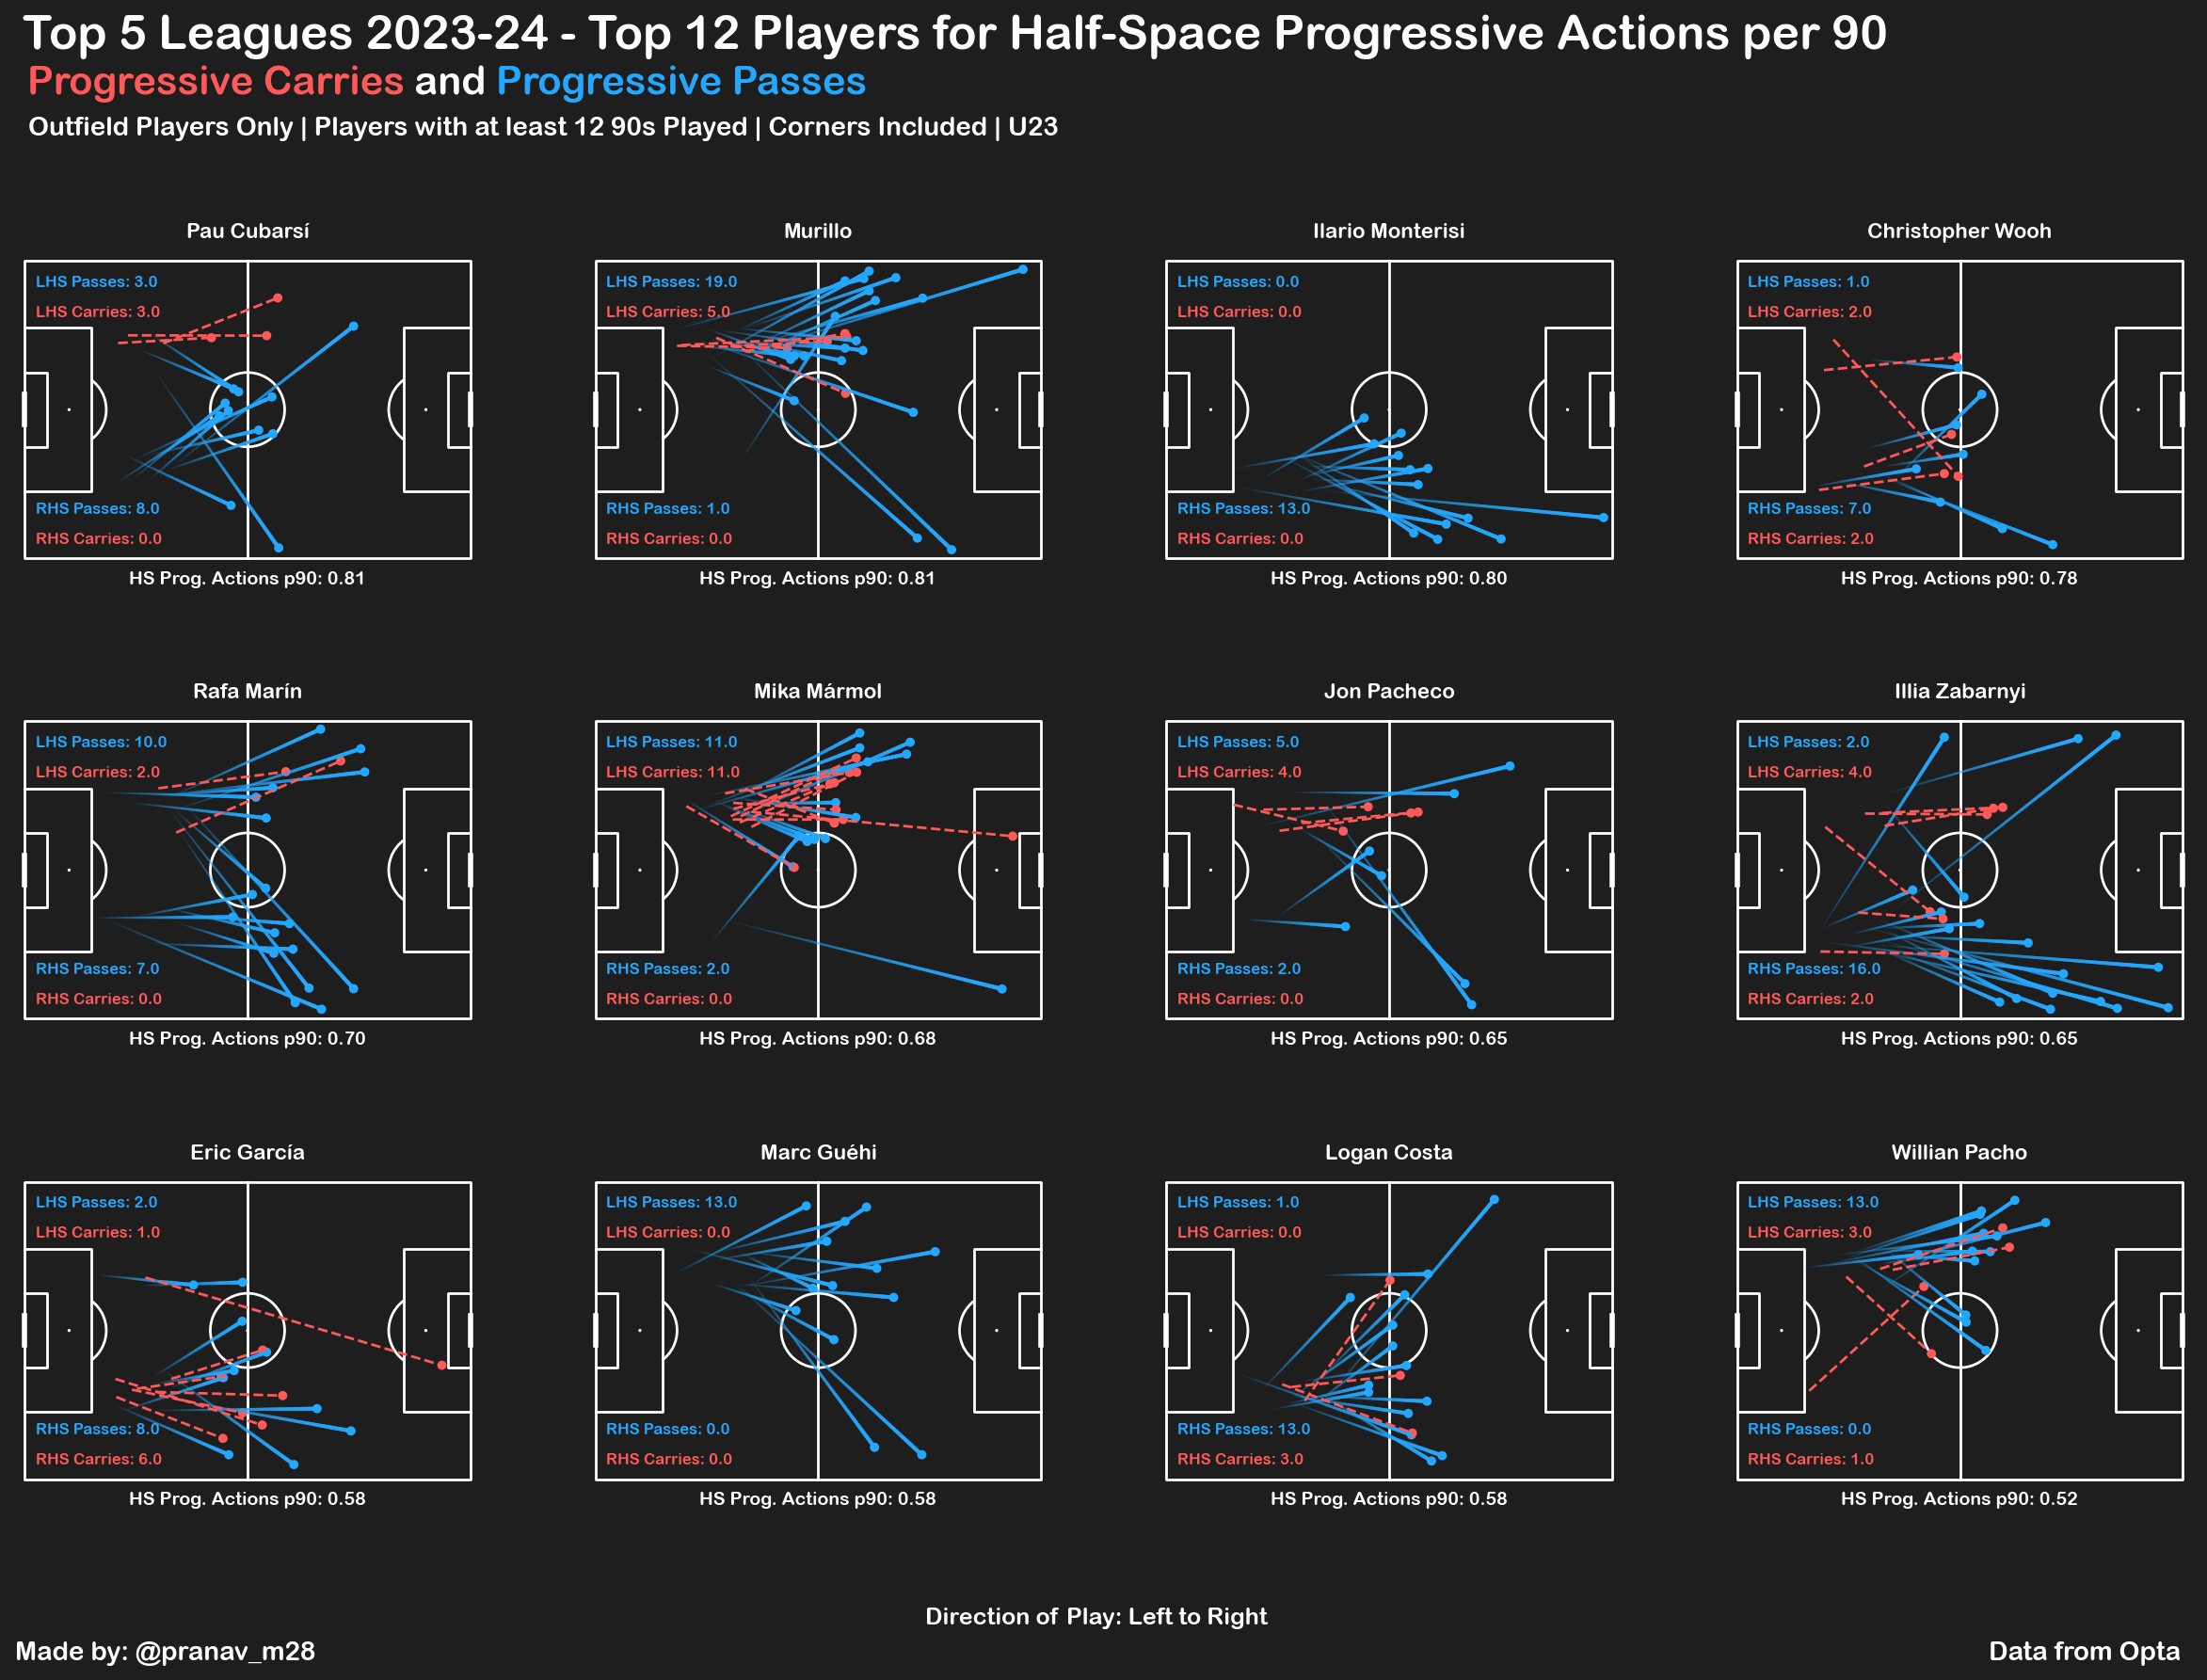

In [88]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
fig.set_facecolor('#1e1e1e')

for ax, (_, player_data) in zip(axs.flatten(), top_12_prog_HS.iterrows()):
    player_id = player_data['playerId']
    player_name = player_data['player']
    
    player_prog_rhs_passes = prog_rhs_passes[prog_rhs_passes['playerId'] == player_id]
    player_prog_rhs_carries = prog_rhs_carries[prog_rhs_carries['playerId'] == player_id]
    player_prog_lhs_passes = prog_lhs_passes[prog_lhs_passes['playerId'] == player_id]
    player_prog_lhs_carries = prog_lhs_carries[prog_lhs_carries['playerId'] == player_id]
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#1e1e1e', line_color='#FFFFFF')
    pitch.draw(ax=ax)
    
    # Plot RHS Progressive Passes
    pitch.lines(player_prog_rhs_passes.x, player_prog_rhs_passes.y, player_prog_rhs_passes.endX, player_prog_rhs_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_prog_rhs_passes.endX, player_prog_rhs_passes.endY, s=50, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
    # Plot RHS Progressive Carries
    pitch.lines(player_prog_rhs_carries.x, player_prog_rhs_carries.y, player_prog_rhs_carries.endX, player_prog_rhs_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_prog_rhs_carries.endX, player_prog_rhs_carries.endY, s=50, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    # Plot LHS Progressive Passes
    pitch.lines(player_prog_lhs_passes.x, player_prog_lhs_passes.y, player_prog_lhs_passes.endX, player_prog_lhs_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_prog_lhs_passes.endX, player_prog_lhs_passes.endY, s=50, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
    # Plot LHS Progressive Carries
    pitch.lines(player_prog_lhs_carries.x, player_prog_lhs_carries.y, player_prog_lhs_carries.endX, player_prog_lhs_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_prog_lhs_carries.endX, player_prog_lhs_carries.endY, s=50, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    ax.invert_yaxis()
    ax.set_title(f'{player_name}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=16)
    
    ax.text(3, 4, f'RHS Carries: {player_data["rhs_prog_carries"]}', color='#FF5959', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(3, 12, f'RHS Passes: {player_data["rhs_prog_passes"]}', font='Arial Rounded MT Bold', color='#24A8FF', fontsize=12, ha='left')
    ax.text(3, 65, f'LHS Carries: {player_data["lhs_prog_carries"]}', color='#FF5959', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(3, 73, f'LHS Passes: {player_data["lhs_prog_passes"]}', font='Arial Rounded MT Bold', color='#24A8FF', fontsize=12, ha='left')
    ax.text(28, -7, f'HS Prog. Actions p90: {player_data["total_prog_actions_p90"]:.2f}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=14, ha='left')

fig_text(0.46, 1.00, "Top 5 Leagues 2023-24 - Top 12 Players for Half-Space Progressive Actions per 90", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=36, fontweight='bold')
fig_text(0.280, 0.97, "<Progressive Carries> and <Progressive Passes>", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=30, fontweight='bold', highlight_textprops=[{"color": '#FF5959'}, {"color": '#24A8FF'}])
fig_text(0.314, 0.94, "Outfield Players Only | Players with at least 12 90s Played | Corners Included | U23", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=20, fontweight='bold')

fig_text(0.18, 0.04, "Made by: @pranav_m28", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.86, 0.04, "Data from Opta", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')


fig_text(
    0.510, 0.060, "Direction of Play: Left to Right", font='Arial Rounded MT Bold' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

#plt.savefig("PL_HS_Prog_into_Act.png" , dpi=300, bbox_inches='tight')
plt.show()
